# Basic Setup

In [ ]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
train_dataset = torchvision.datasets.MNIST(
    root = '.',
    train = True,
    transform = transforms.ToTensor(),
    download = True
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [ ]:
test_dataset = torchvision.datasets.MNIST(
    root='.',
    train=False,
    transform=transforms.ToTensor(),
    download=True)

In [ ]:
print(train_dataset.data.shape)
print(test_dataset.data.shape)

torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])


# Vanilla ANN

In [ ]:
model1 = nn.Sequential(
    nn.Linear(784, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model1.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model1.parameters())

In [ ]:
batch_size = 128
train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size = batch_size, shuffle = False)

In [ ]:
n_epochs = 10

train_losses = np.zeros(n_epochs)
test_losses = np.zeros(n_epochs)

for it in range(n_epochs):
  train_loss = []
  for inputs, targets in train_loader:
    inputs, targets = inputs.to(device), targets.to(device)
    inputs = inputs.view(-1, 784)
    optimizer.zero_grad()
    outputs = model1(inputs)
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()
    train_loss.append(loss.item())
  train_loss = np.mean(train_loss) 
  
  test_loss = []
  for inputs, targets in test_loader:
    inputs, targets = inputs.to(device), targets.to(device)
    inputs = inputs.view(-1, 784)
    outputs = model1(inputs)
    loss = criterion(outputs, targets)
    test_loss.append(loss.item())
  test_loss = np.mean(test_loss)

  train_losses[it] = train_loss
  test_losses[it] = test_loss
    
  print(f'Epoch {it+1}/{n_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

Epoch 1/10, Train Loss: 0.4143, Test Loss: 0.2216
Epoch 2/10, Train Loss: 0.1921, Test Loss: 0.1590
Epoch 3/10, Train Loss: 0.1393, Test Loss: 0.1231
Epoch 4/10, Train Loss: 0.1071, Test Loss: 0.1050
Epoch 5/10, Train Loss: 0.0866, Test Loss: 0.0940
Epoch 6/10, Train Loss: 0.0713, Test Loss: 0.0850
Epoch 7/10, Train Loss: 0.0595, Test Loss: 0.0789
Epoch 8/10, Train Loss: 0.0503, Test Loss: 0.0810
Epoch 9/10, Train Loss: 0.0431, Test Loss: 0.0724
Epoch 10/10, Train Loss: 0.0369, Test Loss: 0.0750


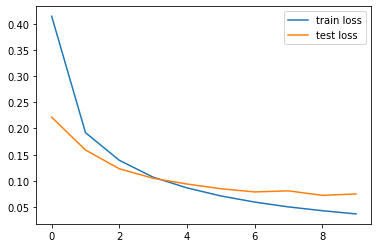

In [ ]:
# Plot the train loss and test loss per iteration
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [ ]:
n_correct = 0
n_total = 0

for inputs, targets in train_loader:
  inputs, targets = inputs.to(device), targets.to(device)
  inputs = inputs.view(-1, 784)
  outputs = model1(inputs)
  _, predictions = torch.max(outputs,1)
  n_correct += (predictions==targets).sum().item()
  n_total += targets.shape[0]
train_acc = n_correct/n_total

n_correct = 0
n_total = 0

for inputs, targets in test_loader:
  inputs, targets = inputs.to(device), targets.to(device)
  inputs = inputs.view(-1, 784)
  outputs = model1(inputs)
  _, predictions = torch.max(outputs,1)
  n_correct += (predictions==targets).sum().item()
  n_total += targets.shape[0]
test_acc = n_correct/n_total

In [ ]:
print(f"Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}")

Train acc: 0.9921, Test acc: 0.9764


# Power Propogation 

In [ ]:
import math

In [ ]:
class PowerPropLinear(nn. Module):
  def __init__(self, in_size, out_size, alpha):
    super().__init__()
    self.in_size = in_size
    self.out_size = out_size
    bias = torch.Tensor(out_size)
    self.bias = nn.Parameter(bias)
    self.alpha = alpha

    super_weights = torch.Tensor(out_size, in_size)
    nn.init.kaiming_uniform_(super_weights, a=math.sqrt(5))
    fan_in, _ = nn.init._calculate_fan_in_and_fan_out(super_weights)
    bound = 1 / math.sqrt(fan_in)
    nn.init.uniform_(self.bias, -bound, bound) 

    abs = torch.abs(super_weights)
    signs = torch.sign(super_weights)
    weights = torch.mul(signs, torch.pow(abs, 1/alpha))
    self.weights = nn.Parameter(weights)

  def forward(self, x):
    super_weights = torch.mul(torch.sign(self.weights), torch.pow(torch.abs(self.weights), self.alpha))
    w_times_x = torch.mm(x, super_weights.t())
    return torch.add(w_times_x, self.bias)

## α = 1.25

In [ ]:
alpha = 1.25

In [ ]:
model2 = nn.Sequential(
    PowerPropLinear(784, 128, alpha),
    nn.ReLU(),
    PowerPropLinear(128, 10, alpha)
)

In [ ]:
model2.to(device)

Sequential(
  (0): PowerPropLinear()
  (1): ReLU()
  (2): PowerPropLinear()
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.parameters())

In [ ]:
batch_size = 128
train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size = batch_size, shuffle = False)

In [ ]:

n_epochs = 10

train_losses = np.zeros(n_epochs)
test_losses = np.zeros(n_epochs)

for it in range(n_epochs):
  train_loss = []
  for inputs, targets in train_loader:
    inputs, targets = inputs.to(device), targets.to(device)
    inputs = inputs.view(-1, 784)
    optimizer.zero_grad()
    outputs = model2(inputs)
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()
    train_loss.append(loss.item())
  train_loss = np.mean(train_loss) 
  
  test_loss = []
  for inputs, targets in test_loader:
    inputs, targets = inputs.to(device), targets.to(device)
    inputs = inputs.view(-1, 784)
    outputs = model2(inputs)
    loss = criterion(outputs, targets)
    test_loss.append(loss.item())
  test_loss = np.mean(test_loss)

  train_losses[it] = train_loss
  test_losses[it] = test_loss
    
  print(f'Epoch {it+1}/{n_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

Epoch 1/10, Train Loss: 0.4990, Test Loss: 0.2592
Epoch 2/10, Train Loss: 0.2236, Test Loss: 0.1886
Epoch 3/10, Train Loss: 0.1658, Test Loss: 0.1476
Epoch 4/10, Train Loss: 0.1297, Test Loss: 0.1259
Epoch 5/10, Train Loss: 0.1056, Test Loss: 0.1089
Epoch 6/10, Train Loss: 0.0874, Test Loss: 0.1004
Epoch 7/10, Train Loss: 0.0736, Test Loss: 0.0906
Epoch 8/10, Train Loss: 0.0632, Test Loss: 0.0854
Epoch 9/10, Train Loss: 0.0541, Test Loss: 0.0798
Epoch 10/10, Train Loss: 0.0467, Test Loss: 0.0783


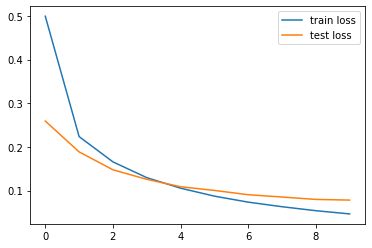

In [ ]:
# Plot the train loss and test loss per iteration
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [ ]:
n_correct = 0
n_total = 0

for inputs, targets in train_loader:
  inputs, targets = inputs.to(device), targets.to(device)
  inputs = inputs.view(-1, 784)
  outputs = model2(inputs)
  _, predictions = torch.max(outputs,1)
  n_correct += (predictions==targets).sum().item()
  n_total += targets.shape[0]
train_acc = n_correct/n_total

n_correct = 0
n_total = 0

for inputs, targets in test_loader:
  inputs, targets = inputs.to(device), targets.to(device)
  inputs = inputs.view(-1, 784)
  outputs = model2(inputs)
  _, predictions = torch.max(outputs,1)
  n_correct += (predictions==targets).sum().item()
  n_total += targets.shape[0]
test_acc = n_correct/n_total



In [ ]:
print(f"Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}")

Train acc: 0.9896, Test acc: 0.9766


## α = 1.5

In [ ]:
alpha = 1.5

In [ ]:
model3 = nn.Sequential(
    PowerPropLinear(784, 128, alpha),
    nn.ReLU(),
    PowerPropLinear(128, 10, alpha)
)

In [ ]:
model3.to(device)

Sequential(
  (0): PowerPropLinear()
  (1): ReLU()
  (2): PowerPropLinear()
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model3.parameters())

In [ ]:
batch_size = 128
train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size = batch_size, shuffle = False)

In [ ]:

n_epochs = 10

train_losses = np.zeros(n_epochs)
test_losses = np.zeros(n_epochs)

for it in range(n_epochs):
  train_loss = []
  for inputs, targets in train_loader:
    inputs, targets = inputs.to(device), targets.to(device)
    inputs = inputs.view(-1, 784)
    optimizer.zero_grad()
    outputs = model3(inputs)
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()
    train_loss.append(loss.item())
  train_loss = np.mean(train_loss) 
  
  test_loss = []
  for inputs, targets in test_loader:
    inputs, targets = inputs.to(device), targets.to(device)
    inputs = inputs.view(-1, 784)
    outputs = model3(inputs)
    loss = criterion(outputs, targets)
    test_loss.append(loss.item())
  test_loss = np.mean(test_loss)

  train_losses[it] = train_loss
  test_losses[it] = test_loss
    
  print(f'Epoch {it+1}/{n_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

Epoch 1/10, Train Loss: 0.5631, Test Loss: 0.2736
Epoch 2/10, Train Loss: 0.2392, Test Loss: 0.1968
Epoch 3/10, Train Loss: 0.1787, Test Loss: 0.1567
Epoch 4/10, Train Loss: 0.1411, Test Loss: 0.1274
Epoch 5/10, Train Loss: 0.1163, Test Loss: 0.1112
Epoch 6/10, Train Loss: 0.0983, Test Loss: 0.1017
Epoch 7/10, Train Loss: 0.0841, Test Loss: 0.0946
Epoch 8/10, Train Loss: 0.0724, Test Loss: 0.0887
Epoch 9/10, Train Loss: 0.0632, Test Loss: 0.0839
Epoch 10/10, Train Loss: 0.0551, Test Loss: 0.0796


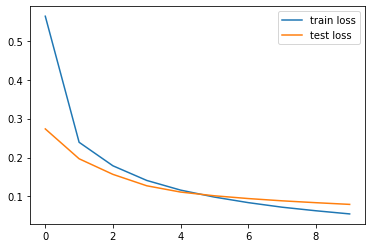

In [ ]:
# Plot the train loss and test loss per iteration
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [ ]:
n_correct = 0
n_total = 0

for inputs, targets in train_loader:
  inputs, targets = inputs.to(device), targets.to(device)
  inputs = inputs.view(-1, 784)
  outputs = model3(inputs)
  _, predictions = torch.max(outputs,1)
  n_correct += (predictions==targets).sum().item()
  n_total += targets.shape[0]
train_acc = n_correct/n_total

n_correct = 0
n_total = 0

for inputs, targets in test_loader:
  inputs, targets = inputs.to(device), targets.to(device)
  inputs = inputs.view(-1, 784)
  outputs = model3(inputs)
  _, predictions = torch.max(outputs,1)
  n_correct += (predictions==targets).sum().item()
  n_total += targets.shape[0]
test_acc = n_correct/n_total



In [ ]:
print(f"Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}")

Train acc: 0.9868, Test acc: 0.9754


# Comparison

In [ ]:
weights1 = np.concatenate((model1[0].weight.cpu().detach().numpy().flatten(), model1[2].weight.cpu().detach().numpy().flatten()))
weights2 = np.concatenate((model2[0].weights.cpu().detach().numpy().flatten(), model2[2].weights.cpu().detach().numpy().flatten()))
weights3 = np.concatenate((model3[0].weights.cpu().detach().numpy().flatten(), model3[2].weights.cpu().detach().numpy().flatten()))

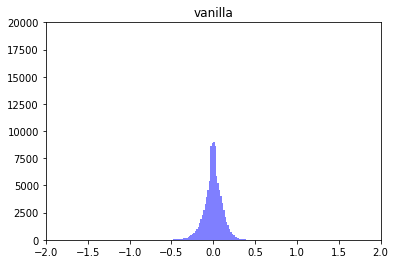

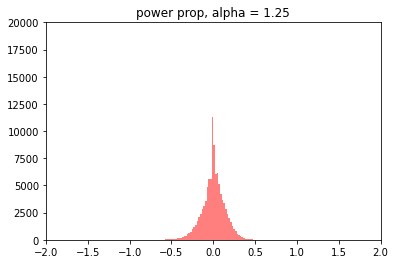

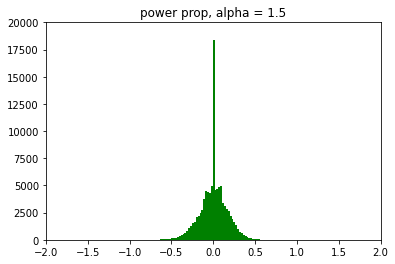

In [ ]:
plt.hist(weights1, bins=100, alpha=0.5, color = "blue")
plt.xlim([-2, 2])
plt.ylim([0, 20000])
plt.title("vanilla")
plt.show()

plt.hist(weights2, bins=100, alpha=0.5, color = "red")
plt.xlim([-2, 2])
plt.ylim([0, 20000])
plt.title("power prop, alpha = 1.25")
plt.show()

plt.hist(weights3, bins=100, color = "green")
plt.xlim([-2, 2])
plt.ylim([0, 20000])
plt.title("power prop, alpha = 1.5")
plt.show()

## What happens at very high α = 4

In [ ]:
alpha = 4

In [ ]:
model4 = nn.Sequential(
    PowerPropLinear(784, 128, alpha),
    nn.ReLU(),
    PowerPropLinear(128, 10, alpha)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model4.parameters())

In [ ]:
batch_size = 128
train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size = batch_size, shuffle = False)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model4.to(device)

cuda:0


Sequential(
  (0): PowerPropLinear()
  (1): ReLU()
  (2): PowerPropLinear()
)

In [ ]:

n_epochs = 10

train_losses = np.zeros(n_epochs)
test_losses = np.zeros(n_epochs)

for it in range(n_epochs):
  train_loss = []
  for inputs, targets in train_loader:
    inputs, targets = inputs.to(device), targets.to(device)
    inputs = inputs.view(-1, 784)
    optimizer.zero_grad()
    outputs = model4(inputs)
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()
    train_loss.append(loss.item())
  train_loss = np.mean(train_loss) 
  
  test_loss = []
  for inputs, targets in test_loader:
    inputs, targets = inputs.to(device), targets.to(device)
    inputs = inputs.view(-1, 784)
    outputs = model4(inputs)
    loss = criterion(outputs, targets)
    test_loss.append(loss.item())
  test_loss = np.mean(test_loss)

  train_losses[it] = train_loss
  test_losses[it] = test_loss
    
  print(f'Epoch {it+1}/{n_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

Epoch 1/10, Train Loss: 0.6655, Test Loss: 0.2848
Epoch 2/10, Train Loss: 0.2542, Test Loss: 0.2111
Epoch 3/10, Train Loss: 0.1841, Test Loss: 0.1582
Epoch 4/10, Train Loss: 0.1410, Test Loss: 0.1275
Epoch 5/10, Train Loss: 0.1141, Test Loss: 0.1148
Epoch 6/10, Train Loss: 0.0951, Test Loss: 0.1036
Epoch 7/10, Train Loss: 0.0810, Test Loss: 0.0961
Epoch 8/10, Train Loss: 0.0706, Test Loss: 0.0920
Epoch 9/10, Train Loss: 0.0610, Test Loss: 0.0906
Epoch 10/10, Train Loss: 0.0542, Test Loss: 0.0863


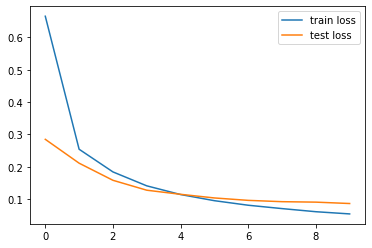

In [ ]:
# Plot the train loss and test loss per iteration
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [ ]:
n_correct = 0
n_total = 0

for inputs, targets in train_loader:
  inputs, targets = inputs.to(device), targets.to(device)
  inputs = inputs.view(-1, 784)
  outputs = model4(inputs)
  _, predictions = torch.max(outputs,1)
  n_correct += (predictions==targets).sum().item()
  n_total += targets.shape[0]
train_acc = n_correct/n_total

n_correct = 0
n_total = 0

for inputs, targets in test_loader:
  inputs, targets = inputs.to(device), targets.to(device)
  inputs = inputs.view(-1, 784)
  outputs = model4(inputs)
  _, predictions = torch.max(outputs,1)
  n_correct += (predictions==targets).sum().item()
  n_total += targets.shape[0]
test_acc = n_correct/n_total



In [ ]:
print(f"Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}")

Train acc: 0.9878, Test acc: 0.9746


In [ ]:
weights4 = np.concatenate((model4[0].weights.cpu().detach().numpy().flatten(), model4[2].weights.cpu().detach().numpy().flatten()))

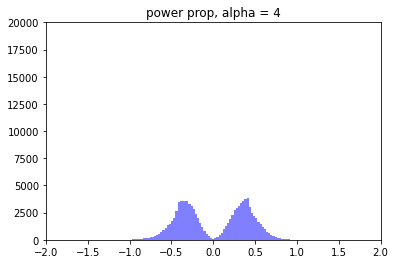

In [ ]:
plt.hist(weights4, bins=100, alpha=0.5, color = "blue")
plt.xlim([-2, 2])
plt.ylim([0, 20000])
plt.title("power prop, alpha = 4")
plt.show()